<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/MachineLearning/How_to_build_an_RNAseq_logistic_regression_classifier_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to build an RNA-seq logistic regression classifier in R
Check out other notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

- **Title:** How to build an RNA-seq logistic regression classifier in R
- **Author:** John Phan
- **Created:** 2021-07-07
- **Purpose:** Demonstrate a basic machine learning method to predict a cancer endpoint using gene expression data.
- **URL:** https://github.com/isb-cgc/Community-Notebooks/blob/master/MachineLearning/How_to_build_an_RNAseq_logistic_regression_classifier_R.ipynb
- **Note:** This example is based on the work published by [Bosquet et al.](https://molecular-cancer.biomedcentral.com/articles/10.1186/s12943-016-0548-9)

This notebook demonstrates how to build a basic machine learning model to predict ovarian cancer treatment outcome. Ovarian cancer gene expression data is pulled from a BigQuery table and formatted using Pandas. The data is then split into training and testing sets to build and test a logistic regression classifier using the R SuperML library. 


## Import Dependencies

In [ ]:
# BigQuery library
if (!require(bigrquery)) {
  print('Installing bigrquery package')
  install.packages('bigrquery')
  if (!require(bigrquery)) {
    print('Cannot install bigrquery package')
  }
}

# Tidyr library
if (!require(tidyr)) {
  print('Installing tidyr package')
  install.packages('tidyr')
  if (!require(tidyr)) {
    print('Cannot install tidyr package')
  }
}

# Caret library for machine learning
if (!require(caret)) {
  print('Installing caret package')
  install.packages('caret')
  if (!require(caret)) {
    print('Cannot install caret package')
  }
}

# SuperML library for machine learning
if (!require(superml)) {
  print('Installing superml package')
  install.packages('superml')
  if (!require(superml)) {
    print('Cannot install superml package')
  }
}

# glmnet library for generalized linear models
if (!require(glmnet)) {
  print('Installing glmnet package')
  install.packages('glmnet')
  if (!require(glmnet)) {
    print('Cannot install glmnet package')
  }
}

# pROC library for calculating AUC
if (!require(pROC)) {
  print('Installing pROC package')
  install.packages('pROC')
  if (!require(pROC)) {
    print('Cannot install pROC package')
  }
}

## Authenticate to Access BigQuery

Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). R notebooks that use the BigRQuery library need the following work-around to authenticate. See the following link: https://gist.github.com/jobdiogenes/235620928c84e604c6e56211ccf681f0

In [ ]:
# NOTE: this cell is only required if you're using Google Colab
if (!require('R.utils')) {
    print('Installing R.utils package')
    install.packages("R.utils")
    if (!require('R.utils')) {
        print('Cannot install R.utils package')
    }
}

if (!require('httr')) {
    print('Installing httr package')
    install.pckages('httr')
    if (!require('httr')) {
        print('Cannot install httr package')
    }
}

my_check <- function() {return(TRUE)}
reassignInPackage("is_interactive", pkgName = "httr", my_check) 
options(rlang_interactive=TRUE)

In [ ]:
# Now authenticate to BQ. Be sure to select the BigQuery scope!
bq_auth(use_oob = TRUE, cache = TRUE)

## Parameters

In [ ]:
# set the google project that will be billed for this notebook's computations
google_project <- 'google-project'

# in this example, we'll be using the Ovarian cancer TCGA dataset
cancer_type <- 'TCGA-OV'

# gene expression data will be pulled from this BigQuery project
bq_project <- 'isb-cgc-bq'

## Get Gene Expression Data from BigQuery Table

Pull RNA-seq gene expression data from the TCGA RNA-seq BigQuery table and join it with the clinical data table to create a labeled data frame. In this example, we will label the samples based on therapy outcome. "Complete Remission/Response" will be labeled as "1" while all other therapy outcomes will be labeled as "0". This prepares the data for binary classification. 

Prediction modeling with RNA-seq data typically requires a feature selection step to reduce the dimensionality of the data before training a classifier. However, to simplify this example, we will use a pre-identified set of 33 genes (Bosquet et al. identified 34 genes, but PRSS2 and its aliases are not available in the hg38 RNA-seq data). 


In [ ]:
# Build query to retrieve gene expression data
ge_query <- sprintf("
  SELECT
    ge.case_barcode AS sample,
    labels.response_label AS label,
    ge.gene_name AS gene_name,
    -- Multiple samples may exist per case, take the max value
    MAX(LOG(ge.fpkm_uq_unstranded+1)) AS gene_expression
  FROM `%s.TCGA_versioned.RNAseq_hg38_gdc_r35` AS ge
  INNER JOIN (
    SELECT
      *
    FROM (
      SELECT
        case_barcode,
        primary_therapy_outcome_success,
        CASE
          -- Complete Reponse    --> label as 1
          -- All other responses --> label as 0
          WHEN primary_therapy_outcome_success = 'Complete Remission/Response' THEN 1
          WHEN (primary_therapy_outcome_success IN (
            'Partial Remission/Response','Progressive Disease','Stable Disease'
          )) THEN 0
        END AS response_label
        FROM `%s.TCGA_versioned.clinical_gdc_2019_06`
        WHERE
          project_short_name = '%s'
          AND primary_therapy_outcome_success IS NOT NULL
    )
  ) labels
  ON labels.case_barcode = ge.case_barcode
  WHERE gene_name IN ( -- 33 Gene signature, leave out PRSS2 (aka TRYP2)
    'RHOT1','MYO7A','ZBTB10','MATK','ST18','RPS23','GCNT1','DROSHA','NUAK1','CCPG1',
    'PDGFD','KLRAP1','MTAP','RNF13','THBS1','MLX','FAP','TIMP3','PRSS1','SLC7A11',
    'OLFML3','RPS20','MCM5','POLE','STEAP4','LRRC8D','WBP1L','ENTPD5','SYNE1','DPT',
    'COPZ2','TRIO','PDPR'
  )
  GROUP BY sample, label, gene_name
", bq_project, bq_project, cancer_type)

# Run the query
ge_table <- bq_project_query(google_project, ge_query, quiet = TRUE)

# Download the query result
ge_data <- bq_table_download(ge_table, quiet = TRUE)

# Show the dataframe
str(ge_data)

tibble [8,712 × 4] (S3: tbl_df/tbl/data.frame)
 $ sample         : chr [1:8712] "TCGA-24-1423" "TCGA-24-1563" "TCGA-25-1326" "TCGA-24-2036" ...
 $ label          : int [1:8712] 1 1 0 1 1 1 1 1 0 1 ...
 $ gene_name      : chr [1:8712] "POLE" "TRIO" "PDGFD" "POLE" ...
 $ gene_expression: num [1:8712] 10.3 11.5 11.5 12 10.4 ...


## Reshape the Data

The data pulled from BigQuery is formatted such that each row corresponds to a sample/gene combination. However, to use the data with scikit-learn, it is more convenient to reshape the data such that each row corresponds to a sample and each column corresponds to a gene. We'll use tidyr spread() function to pivot the data.


In [ ]:
# Pivot the data frame with spread()
ge_data_pivot <- spread(ge_data, key = "gene_name", value = "gene_expression")

# Display pivoted data frame
str(ge_data_pivot)

tibble [264 × 35] (S3: tbl_df/tbl/data.frame)
 $ sample : chr [1:264] "TCGA-04-1331" "TCGA-04-1341" "TCGA-04-1343" "TCGA-04-1347" ...
 $ label  : int [1:264] 1 1 0 1 0 0 0 0 1 1 ...
 $ CCPG1  : num [1:264] 10.5 10.6 10.9 10.7 10.2 ...
 $ COPZ2  : num [1:264] 11.1 12 12.6 11.1 10.4 ...
 $ DPT    : num [1:264] 10.01 10.22 11.12 9.65 6.81 ...
 $ DROSHA : num [1:264] 12.3 12.5 11.8 12.2 12.4 ...
 $ ENTPD5 : num [1:264] 10.78 10.35 10.41 9.97 11.52 ...
 $ FAP    : num [1:264] 10.28 9.94 10.75 9.04 0 ...
 $ GCNT1  : num [1:264] 12.59 9.11 9.79 10.76 10.62 ...
 $ KLRAP1 : num [1:264] 11.37 10.55 9.74 10.46 9.82 ...
 $ LRRC8D : num [1:264] 12.6 12.1 12.3 13 12.3 ...
 $ MATK   : num [1:264] 8.5 10.12 11.18 7.92 8.17 ...
 $ MCM5   : num [1:264] 12.7 12.3 12.6 12.6 11.8 ...
 $ MLX    : num [1:264] 11.8 12.9 12.2 12.5 11.7 ...
 $ MTAP   : num [1:264] 11.2 10.4 10.3 10.6 10.6 ...
 $ MYO7A  : num [1:264] 8.26 11.44 9.63 8.87 9.13 ...
 $ NUAK1  : num [1:264] 11.3 10.8 11.3 10.4 9.4 ...
 $ OLFML3 : nu

## Prepare the Data for Prediction Modeling

Prepare the data by splitting it into training and testing sets, and scaling the data. It is important that prediction models are tested on samples that are independent from the training samples in order to accurately estimate performance. 


In [ ]:
# remove the sample names column from the data frame
ge_data_pivot_nosample <- subset(ge_data_pivot, select=-c(sample))

# use the caret createDataPartition function to create a balanced split of the data into train and test sets
set.seed(10)
train_rows = createDataPartition(ge_data_pivot_nosample$label, p=0.5, list=FALSE, times=1)
train_data <- ge_data_pivot_nosample[train_rows,]
test_data <- ge_data_pivot_nosample[-train_rows,]

# move labels to their own variables
train_y <- train_data$label
test_y <- test_data$label

# use caret's preProcess function to scale the data to 0 mean and unit variance
pre_proc_vals <- preProcess(subset(train_data, select=-c(label)), method=c('center', 'scale'))
train_x <- predict(pre_proc_vals, subset(train_data, select=-c(label)))
test_x <- predict(pre_proc_vals, subset(test_data, select=-c(label)))

# recombine the data and labels
train_data <- train_x
train_data$label <- train_y
test_data <- test_x
test_data$label <- test_y

## Train and Test the Prediction Model

We use a simple logistic regression classifier implemented in the "SuperML" R package. SuperML was designed to be very similar to the Python scikit-learn package for machine learning. More information about the SuperML can be found [here](https://rdrr.io/cran/superml/f/vignettes/introduction.Rmd). After training the classifier using the "fit" function, we use the "predict" function to predict a decision value for each sample in the test dataset. Because the dataset may not be balanced in terms of the number of samples in each class, we use AUC, or Area Under the ROC curve, to assess prediction performance. The decision values are used to calculate the AUC, with higher AUC values indicating better prediction performance. An AUC of 1 indicates perfect prediction. More information about accuracy, AUC, and other classification performance metrics can be found in the [Google Machine Learning crash course](https://developers.google.com/machine-learning/crash-course/classification/video-lecture). Read about AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).  

In [ ]:
# Create an instance of the model using the superml Linear Model trainer and 
# the binomial family for logistic regression classification
model <- LMTrainer$new(family = 'binomial')

# Fit the model with the training data
model$fit(X=train_data, y='label')
summary(model$model)

# Predict samples in the test data
predictions <- model$predict(df=test_data)

# Evaluate performance using AUC
auc_value <- auc(test_data$label, predictions)
print(sprintf('Prediction Performance (AUC): %s', auc_value))


Call:
stats::glm(formula = f, family = self$family, data = X, weights = self$weights)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4077  -0.8051   0.3323   0.7529   1.7680  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.37915    0.29223   4.719 2.37e-06 ***
CCPG1       -0.10863    0.40005  -0.272   0.7860    
COPZ2        0.22430    0.56831   0.395   0.6931    
DPT         -0.34782    0.51897  -0.670   0.5027    
DROSHA       0.12363    0.36257   0.341   0.7331    
ENTPD5       0.26706    0.34229   0.780   0.4353    
FAP          0.17426    0.64122   0.272   0.7858    
GCNT1        0.27284    0.32335   0.844   0.3988    
KLRAP1      -0.01840    0.33708  -0.055   0.9565    
LRRC8D       0.49565    0.30413   1.630   0.1032    
MATK        -0.38799    0.33643  -1.153   0.2488    
MCM5        -0.16778    0.36915  -0.455   0.6495    
MLX          0.71550    0.45484   1.573   0.1157    
MTAP         0.15597    0.28732   0.543   

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Prediction Performance (AUC): 0.713391739674593"


## Evaluate Prediction Performance

The prediction performance AUC of 0.71 is within the performance range (0.7 to 0.8) of the models developed by Bosquet et al. Note that if the "random_state" value is changed in the train/test split step, prediction performance will vary. Thus, a better method for assessing performance would be to generate multiple permutations of train/test datasets, calculate prediction performance for each permutation, and report the mean and standard deviation of AUC.


In [ ]:
num_iters <- 100
auc_vals <- c()

for (i in 1:num_iters) {
  # use the caret createDataPartition function to create a balanced split of the data into train and test sets
  train_rows = createDataPartition(ge_data_pivot_nosample$label, p=0.5, list=FALSE, times=1)
  train_data <- ge_data_pivot_nosample[train_rows,]
  test_data <- ge_data_pivot_nosample[-train_rows,]

  # move labels to their own variables
  train_y <- train_data$label
  test_y <- test_data$label

  # use caret's preProcess function to scale the data to 0 mean and unit variance
  pre_proc_vals <- preProcess(subset(train_data, select=-c(label)), method=c('center', 'scale'))
  train_x <- predict(pre_proc_vals, subset(train_data, select=-c(label)))
  test_x <- predict(pre_proc_vals, subset(test_data, select=-c(label)))

  # recombine the data and labels
  train_data <- train_x
  train_data$label <- train_y
  test_data <- test_x
  test_data$label <- test_y

  # Create an instance of the model using the superml Linear Model trainer and 
  # the binomial family for logistic regression classification
  model <- LMTrainer$new(family = 'binomial')

  # Fit the model with the training data
  model$fit(X=train_data, y='label')

  # Predict samples in the test data
  predictions <- model$predict(df=test_data)

  # Evaluate performance using AUC
  auc_val <- auc(test_data$label, predictions)
  auc_vals[i] <- auc_val
}

print(sprintf('AUC Mean: %s', mean(auc_vals)))
print(sprintf('AUC Standard Deviation: %s', sd(auc_vals)))

## Visualize and Interpret Results

We can use data visualization to help interpret the classifier's performance. Although our initial prediction result was 0.71, the average prediction result over several random permutations of the data is actually below 0.7, with a range spanning approximately 0.6 to 0.7. An AUC of 0.7 can be interpreted as a 70% chance that the classifier's prediction (i.e., "Complete Remission/Response" or not) is correct. 

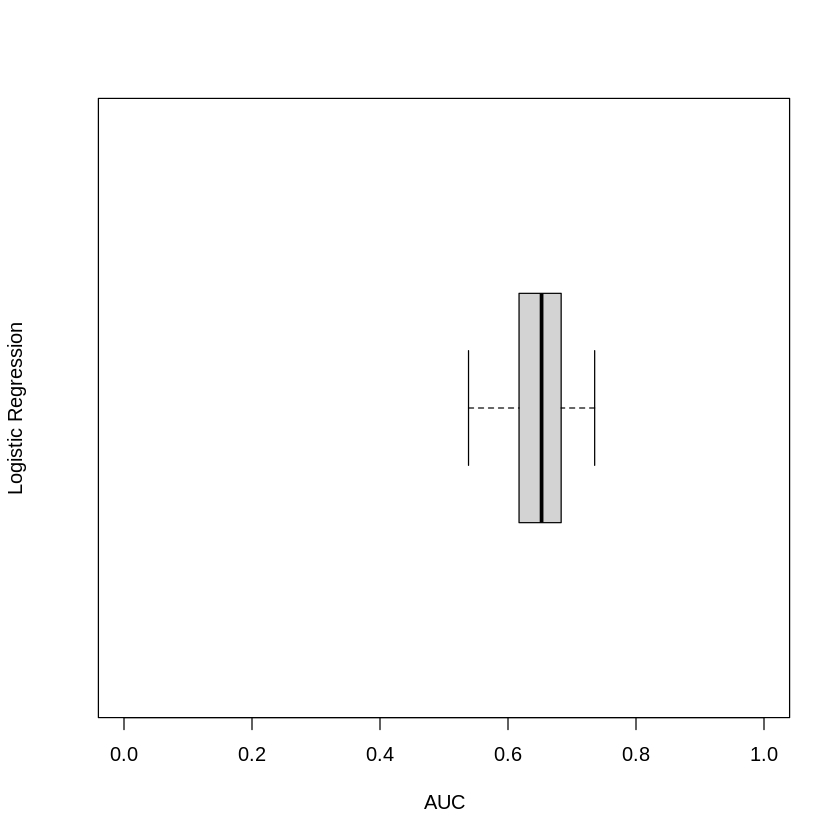

In [ ]:
# use a boxplot to visualize the AUC results
boxplot(auc_vals, ylab='Logistic Regression', xlab='AUC', horizontal=TRUE, ylim=c(0, 1))

## Next Steps

The model trained and stored in the "model" variable can now be used to predict therapeutic outcome of future RNA-seq ovarian cancer samples. If the model has been trained to generalize well to the problem of predicting Ovarian cancer therapeutic outcome, we would expect that future predictions would yield up to a 70% probability of being correct. However, an inherent problem with estimating machine learning performance is its dependence on the data. Thus, if future RNA-seq samples differ from the training data (e.g., different biological population, different sequencing method or instrument, or different data normalization method), we cannot make any assumptions about the model's prediction of those samples. In addition, if the testing data in our original assessment is different from the training data, then our performance estimation of 0.7 AUC may not be reliable. See [Zhang et al.](https://academic.oup.com/nargab/article/2/3/lqaa078/5909519) for more information about RNA-seq batch effects. 

As an example, suppose that we have a future sample to predict:

In [ ]:
# For this example, we'll just take a single sample out of our previous test
# dataset. However, in practical applications, the future sample usually comes
# from new, independent datasets. 
future_sample = test_data[10,]

# Predict the therapeutic outcome of the future sample using the "predict" 
# function, which will give us a label of either 0 or 1
sample_prediction <- model$predict(df=future_sample)

# The predict function actually returns a decision value, which needs to be
# thresholded to obtain a prediction label. In this case the threshold is 0.5 and
# decision values >0.5 are labeled "1" while decision values <=0.5 are 
# labeled "0".
prediction_label <- if (sample_prediction > 0.5) 1 else 0
print(sprintf("Decision value: %s", sample_prediction))
print(sprintf("Prediction label: %s", prediction_label))

[1] "Decision value: 0.578681841679563"
[1] "Prediction label: 1"


A predicted label of "1" means that this future sample is predicted to have "Complete Remission/Response", while a predicted label of "0" means that this future sample is predicted to have "No Response" to therapy. This prediction process can be repeated for any number of future samples.